In [35]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [36]:
DATA_DIR = './titanic'
data_files = reversed([os.path.join(DATA_DIR, filename) for filename in os.listdir(DATA_DIR)])
df_list = []
for filename in data_files:
    df_list.append(pd.read_csv(filename))
df = pd.concat(df_list, sort=False)
df = df.reset_index(drop=True)

number_of_train_dataset = df.Survived.notnull().sum()
number_of_test_dataset = df.Survived.isnull().sum() 
y_true = df.pop("Survived")[:number_of_train_dataset]

df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,3,"Spector, Mr. Woolf",male,nan,0,0,A.5. 3236,8.05,NaN,S
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S
1307,1308,3,"Ware, Mr. Frederick",male,nan,0,0,359309,8.05,NaN,S
1308,1309,3,"Peter, Master. Michael J",male,nan,1,1,2668,22.36,NaN,C


In [37]:
df.dtypes
df.info()
df.isnull().sum()
df.describe()
df.head(2).T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


,0,1
PassengerId,1,2
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22.00,38.00
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.28
Cabin,NaN,C85


In [38]:
pd.options.display.float_format = '{:.2f}'.format
df.isnull().sum() / len(df) * 100

PassengerId    0.00
Pclass         0.00
Name           0.00
Sex            0.00
Age           20.09
SibSp          0.00
Parch          0.00
Ticket         0.00
Fare           0.08
Cabin         77.46
Embarked       0.15
dtype: float64

In [39]:
df[df["Age"].notnull()].groupby(["Sex"])["Age"].mean()

Sex
female   28.69
male     30.59
Name: Age, dtype: float64

In [40]:
df[df["Age"].notnull()].groupby(["Pclass"])["Age"].mean()

Pclass
1   39.16
2   29.51
3   24.82
Name: Age, dtype: float64

In [41]:
df["Age"].fillna(
    df.groupby("Pclass")["Age"].transform("mean"), inplace=True)
df.isnull().sum() / len(df) * 100

PassengerId    0.00
Pclass         0.00
Name           0.00
Sex            0.00
Age            0.00
SibSp          0.00
Parch          0.00
Ticket         0.00
Fare           0.08
Cabin         77.46
Embarked       0.15
dtype: float64

In [42]:
df.groupby("Pclass")["Age"].transform("mean")

0      24.82
1      39.16
2      24.82
3      39.16
4      24.82
        ... 
1304   24.82
1305   39.16
1306   24.82
1307   24.82
1308   24.82
Name: Age, Length: 1309, dtype: float64

### One-hot encoding

In [43]:
object_columns = ["PassengerId", "Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
numeric_columns = ["Age", "SibSp", "Parch", "Fare"]

In [44]:
for col_name in object_columns:
    df[col_name] = df[col_name].astype(object)

for col_name in numeric_columns:
    df[col_name] = df[col_name].astype(float)
df["Parch"] = df["Parch"].astype(int)
df["SibSp"] = df["SibSp"].astype(int)


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null object
Pclass         1309 non-null object
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int32
Parch          1309 non-null int32
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int32(2), object(7)
memory usage: 102.4+ KB


In [46]:
def merge_and_get(ldf, rdf, on, how="inner", index=None):
    if index is True:
        return pd.merge(ldf,rdf, how=how, left_index=True, right_index=True)
    else:
        return pd.merge(ldf,rdf, how=how, on=on)

In [47]:
df.loc[61,"Embarked"]           = "S"
df.loc[829,"Embarked"]           = "S"

In [175]:
one_hot_df = merge_and_get(df, pd.get_dummies(df["Sex"], prefix="Sex"), on=None, index=True) #sex_modified
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Pclass"], prefix="Pclass"), on=None, index=True) #sex_modified
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Embarked"], prefix="Embarked"), on=None, index=True) #sex_modified
# del one_hot_df["Sex"]
# del one_hot_df["Pclass"]
# del one_hot_df["Embarked"]

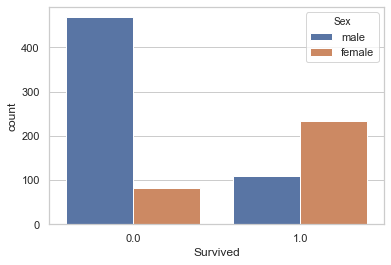

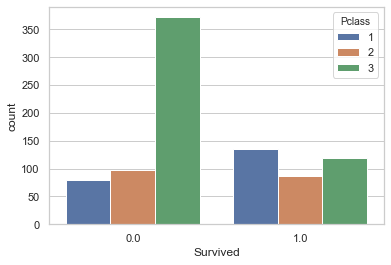

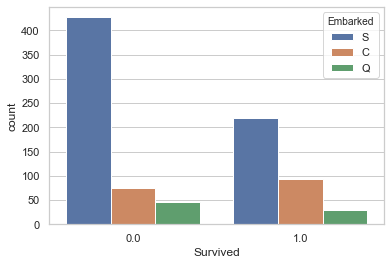

In [176]:
temp_columns = ["Sex", "Pclass", "Embarked"]

for col_name in temp_columns:
    temp_df = pd.merge(one_hot_df[col_name], y_true, left_index=True, right_index=True)
    sns.countplot(x="Survived", hue=col_name, data=temp_df)
    plt.show()

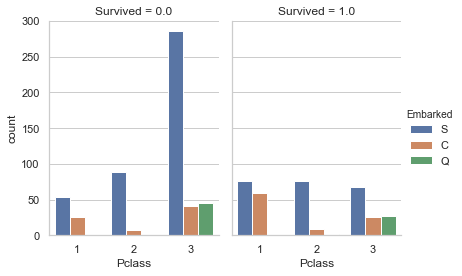

In [177]:
temp_df = pd.merge(one_hot_df[temp_columns], y_true, left_index=True, right_index=True)
g = sns.catplot(x="Pclass", hue="Embarked", col="Survived",
                 data=temp_df, kind="count",
                 height=4, aspect=.7);

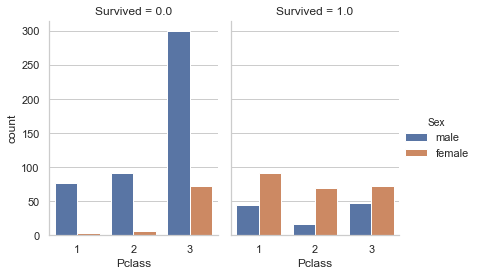

In [178]:
temp_df = pd.merge(one_hot_df[temp_columns], y_true, left_index=True, right_index=True)
g = sns.catplot(x="Pclass", hue="Sex", col="Survived",
                 data=temp_df, kind="count",
                 height=4, aspect=.7);

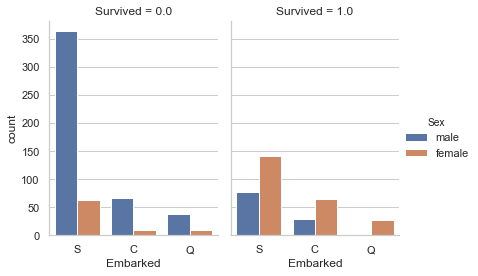

In [179]:
temp_df = pd.merge(one_hot_df[temp_columns], y_true, left_index=True, right_index=True)
g = sns.catplot(x="Embarked", hue="Sex", col="Survived",
                 data=temp_df, kind="count",
                 height=4, aspect=.7);

In [180]:
one_hot_df["Sex"]

0         male
1       female
2       female
3       female
4         male
         ...  
1304      male
1305    female
1306      male
1307      male
1308      male
Name: Sex, Length: 1309, dtype: object

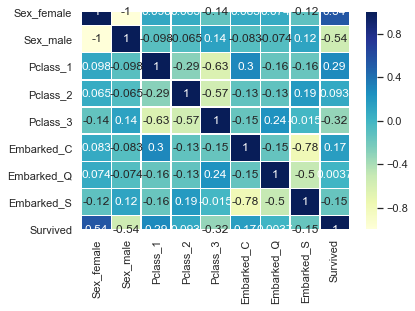

In [307]:
crosscheck_columns = [col_name for col_name in one_hot_df.columns.tolist()
                     if col_name.split("_")[0] in temp_columns and  "_"  in col_name ] + ["Sex"]

# temp_columns
temp_df = pd.merge(one_hot_df[crosscheck_columns], y_true, left_index=True, right_index=True)

corr =  temp_df.corr()
sns.set()
ax = sns.heatmap(corr, annot=True,  linewidths=.5, cmap="YlGnBu")

### Mean Encoding

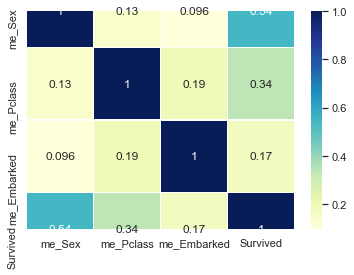

In [366]:
temp_columns = ["Sex", "Pclass", "Embarked"]

me_list = []
for col_name in temp_columns:
    temp_df = pd.merge(one_hot_df[col_name], y_true, left_index=True, right_index=True)
    temp_df["me_"+col_name] = temp_df[col_name].replace(temp_df.groupby(col_name)["Survived"].mean())
#     sns.countplot(x=col_name, hue="Survived", data=temp_df)    
#     plt.show()
#     sns.countplot(x="me_"+col_name, hue="Survived", data=temp_df)
#     plt.show()
    
    me_list.append(temp_df.drop("Survived", axis=1))
temp_df =  pd.merge(
    pd.concat(me_list,axis=1)[["me_" + col_name for col_name in temp_columns ]],
    y_true, left_index=True, right_index=True)
corr =  temp_df.corr()
sns.set()
ax = sns.heatmap(corr, annot=True,  linewidths=.5, cmap="YlGnBu")

### Numeric data types

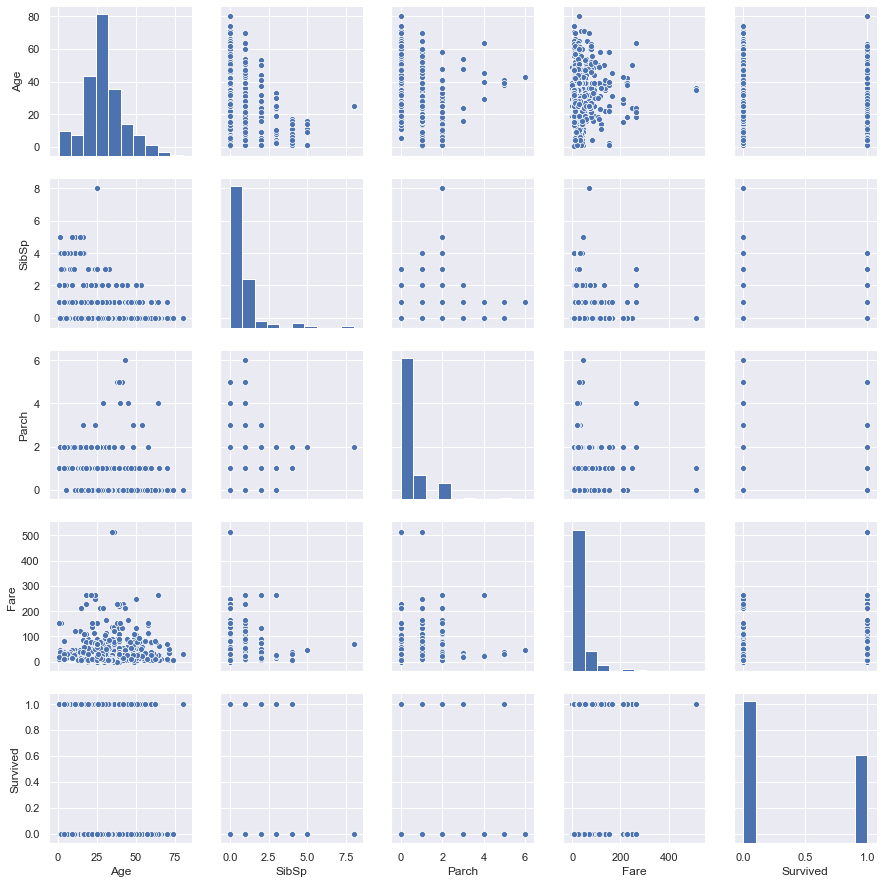

In [191]:
temp_df = pd.merge(one_hot_df[numeric_columns], y_true, left_index=True, right_index=True)

sns.pairplot(temp_df)

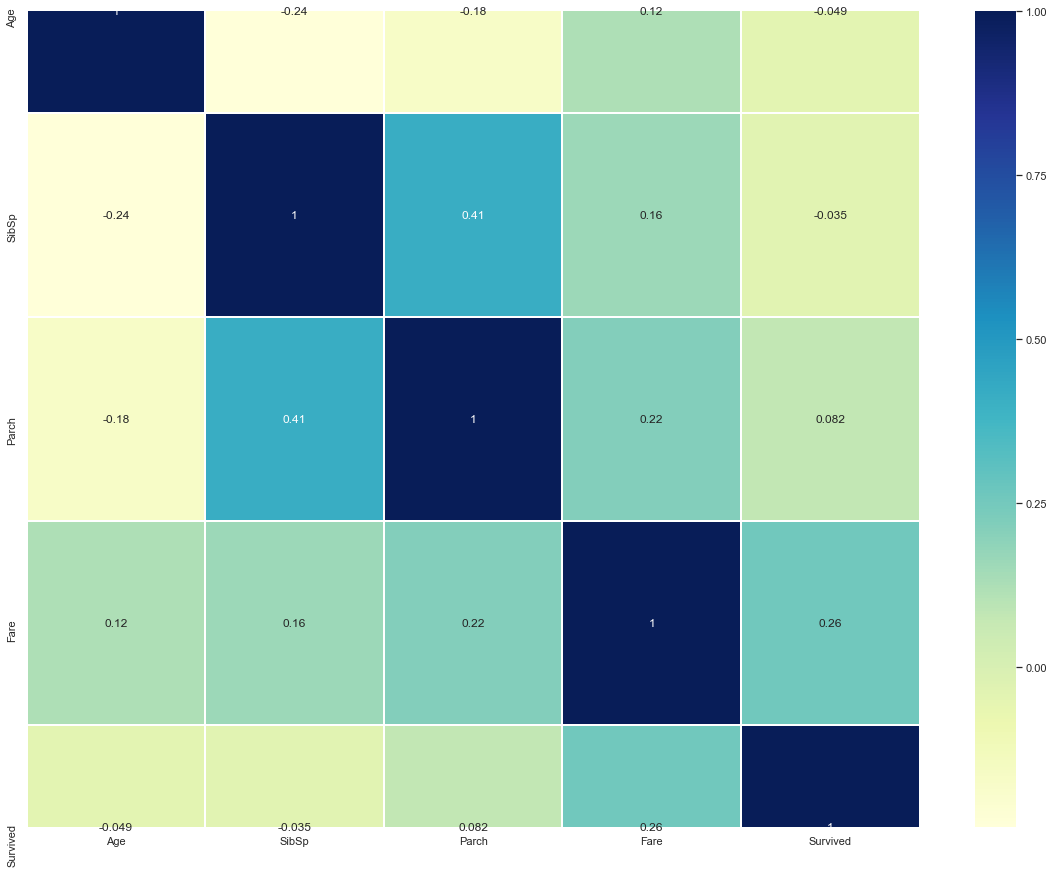

In [198]:
corr =  temp_df.corr()
sns.set()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, annot=True,  linewidths=.8, cmap="YlGnBu")

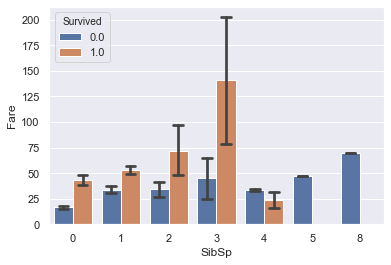

In [210]:
sns.barplot(x="SibSp", y="Fare", hue="Survived", data=temp_df, ci=68, capsize=.2)

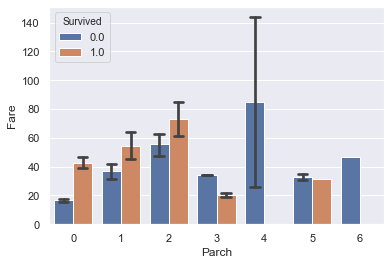

In [212]:
sns.barplot(x="Parch", y="Fare", hue="Survived", data=temp_df, ci=68, capsize=.2)

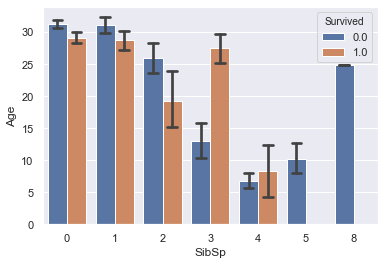

In [215]:
sns.barplot(x="SibSp", y="Age", hue="Survived", data=temp_df, ci=68, capsize=.2)

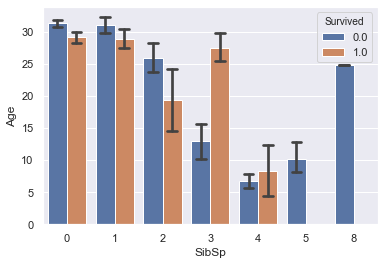

In [216]:
sns.barplot(x="SibSp", y="Age", hue="Survived", data=temp_df, ci=68, capsize=.2)

### Bining 

In [219]:
one_hot_df["Fare"].value_counts()

8.05     60
13.00    59
7.75     55
26.00    50
7.90     49
         ..
33.50     1
7.80      1
26.39     1
15.58     1
7.14      1
Name: Fare, Length: 281, dtype: int64

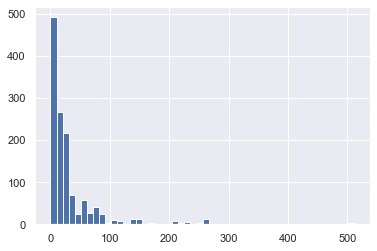

In [220]:
one_hot_df["Fare"].hist(bins=50)

In [221]:
one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,1,0,1,0,0,1,0,0
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,1,0,1,0,0,0,0,1
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.82,0,0,A.5. 3236,8.05,NaN,S,0,1,0,0,1,0,0,1
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C,1,0,1,0,0,1,0,0
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S,0,1,0,0,1,0,0,1
1307,1308,3,"Ware, Mr. Frederick",male,24.82,0,0,359309,8.05,NaN,S,0,1,0,0,1,0,0,1


d:\ProgramData\Miniconda3\envs\ml\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
d:\ProgramData\Miniconda3\envs\ml\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


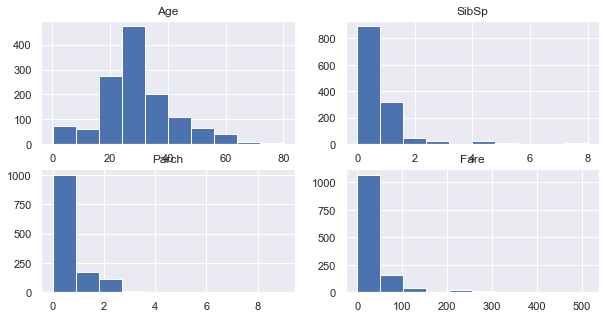

In [222]:
fig = plt.figure()
fig.set_size_inches(10,5) # 싸이즈 설정

ax = []
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, col_name in enumerate(numeric_columns):
    ax.append(fig.add_subplot(2,2,i+1)) # 두개의 plot 생성
    X_1 = one_hot_df[col_name]
    
    ax[i].hist(X_1)
    ax[i].set_title(col_name)

In [223]:
df["Parch"].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [224]:
bins = [-1, 0, 2, 5, 9]
group_name = ["l1", "l2", "l3", "l4"]

bin_one_hot_df = merge_and_get(one_hot_df,
    pd.get_dummies(pd.cut(df["Parch"], bins, labels=group_name ), prefix="parch"), on=None, index=True)

bins = [-1, 0, 1, 4, 10]
group_name = ["l1", "l2", "l3", "l4"]
bin_one_hot_df = merge_and_get(bin_one_hot_df,
    pd.get_dummies(pd.cut(df["SibSp"], bins, labels=group_name ), prefix="SibSp"), on=None, index=True)

bin_one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Embarked_Q,Embarked_S,parch_l1,parch_l2,parch_l3,parch_l4,SibSp_l1,SibSp_l2,SibSp_l3,SibSp_l4
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,...,0,1,1,0,0,0,0,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,...,0,0,1,0,0,0,0,1,0,0
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,...,0,1,1,0,0,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,...,0,1,1,0,0,0,0,1,0,0
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,...,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.82,0,0,A.5. 3236,8.05,NaN,...,0,1,1,0,0,0,1,0,0,0
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,...,0,0,1,0,0,0,1,0,0,0
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,...,0,1,1,0,0,0,1,0,0,0
1307,1308,3,"Ware, Mr. Frederick",male,24.82,0,0,359309,8.05,NaN,...,0,1,1,0,0,0,1,0,0,0


### Log Transform

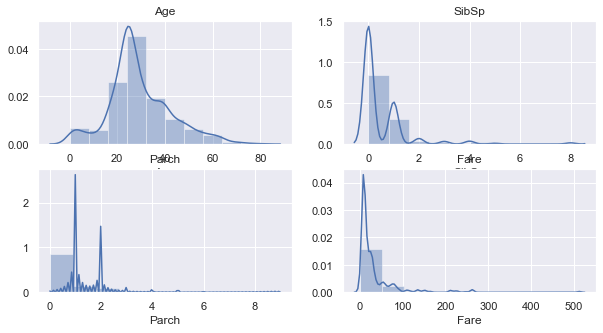

In [302]:
fig = plt.figure()
fig.set_size_inches(10,5) # 싸이즈 설정

ax = []
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, col_name in enumerate(numeric_columns):
    ax.append(fig.add_subplot(2,2,i+1)) # 두개의 plot 생성
    X_1 = bin_one_hot_df[col_name]
    
    ax[i] = sns.distplot(X_1, bins=10)
    ax[i].set_title(col_name)

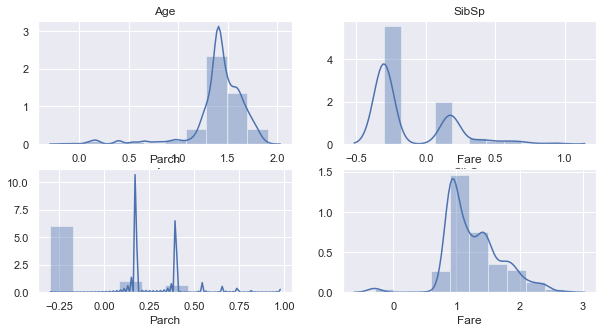

In [303]:
fig = plt.figure()
fig.set_size_inches(10,5) # 싸이즈 설정

ax = []
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, col_name in enumerate(numeric_columns):
    ax.append(fig.add_subplot(2,2,i+1)) # 두개의 plot 생성
    X_1 = np.log10(bin_one_hot_df[col_name]+0.5)
    
    ax[i]= sns.distplot(X_1, bins=10)
    ax[i].set_title(col_name)

In [227]:
bin_one_hot_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          0
Sex_female        0
Sex_male          0
Pclass_1          0
Pclass_2          0
Pclass_3          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
parch_l1          0
parch_l2          0
parch_l3          0
parch_l4          0
SibSp_l1          0
SibSp_l2          0
SibSp_l3          0
SibSp_l4          0
dtype: int64

In [228]:
bin_one_hot_df["Fare"] = bin_one_hot_df["Fare"].fillna(bin_one_hot_df["Fare"].mean())
# bin_one_hot_df.isnull().sum()

In [229]:
log_bin_one_hot_df = merge_and_get(bin_one_hot_df, np.log10(bin_one_hot_df["Fare"]+0.5), on=None, index=True)

log_bin_one_hot_df.rename(columns={'Fare_x':'base_fare',
                          'Fare_y':'log_fare'}, 
                 inplace=True)
log_bin_one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,base_fare,Cabin,...,Embarked_S,parch_l1,parch_l2,parch_l3,parch_l4,SibSp_l1,SibSp_l2,SibSp_l3,SibSp_l4,log_fare
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,...,1,1,0,0,0,0,1,0,0,0.89
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,...,0,1,0,0,0,0,1,0,0,1.86
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,...,1,1,0,0,0,1,0,0,0,0.93
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,...,1,1,0,0,0,0,1,0,0,1.73
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,...,1,1,0,0,0,1,0,0,0,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.82,0,0,A.5. 3236,8.05,NaN,...,1,1,0,0,0,1,0,0,0,0.93
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,...,0,1,0,0,0,1,0,0,0,2.04
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,...,1,1,0,0,0,1,0,0,0,0.89
1307,1308,3,"Ware, Mr. Frederick",male,24.82,0,0,359309,8.05,NaN,...,1,1,0,0,0,1,0,0,0,0.93


### String handling

In [230]:
from collections import Counter
Counter((log_bin_one_hot_df["Name"].str.lower() + " ").sum().split()).most_common(3)

[('mr.', 757), ('miss.', 260), ('mrs.', 197)]

In [231]:
log_bin_one_hot_df["is_mr"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'mr.') 
log_bin_one_hot_df["is_miss"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'miss.') 
log_bin_one_hot_df["is_mrs"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'mrs.') 

In [232]:
log_bin_one_hot_df["Ticket"].str.rsplit(expand=True, )

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
1304,A.5.,3236,None
1305,PC,17758,None
1306,SOTON/O.Q.,3101262,None
1307,359309,None,None


In [233]:
log_bin_one_hot_df["Ticket"].str.extractall('(\d+)')

0
     match         
0    0            5
     1        21171
1    0        17599
2    0            2
     1      3101282
...             ...
1304 1         3236
1305 0        17758
1306 0      3101262
1307 0       359309
1308 0         2668

[1373 rows x 1 columns]

In [234]:
Counter((log_bin_one_hot_df["Ticket"].str.lower() + " ").sum().split()).most_common(30)

[('pc', 92),
 ('c.a.', 46),
 ('sc/paris', 16),
 ('soton/o.q.', 16),
 ('2.', 15),
 ('w./c.', 14),
 ('ston/o', 14),
 ('a/5', 12),
 ('ca.', 12),
 ('2343', 11),
 ('a/5.', 10),
 ('ca', 10),
 ('f.c.c.', 9),
 ('2144', 8),
 ('1601', 8),
 ('soton/oq', 8),
 ('c', 8),
 ('ston/o2.', 7),
 ('347082', 7),
 ('347077', 7),
 ('3101295', 7),
 ('s.o.c.', 7),
 ('14879', 7),
 ('17608', 7),
 ('s.o./p.p.', 7),
 ('382652', 6),
 ('19950', 6),
 ('347088', 6),
 ('113781', 6),
 ('a/4', 6)]

In [235]:
log_bin_one_hot_df["is_pc"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'pc') 
log_bin_one_hot_df["is_ca"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'c.a.')  | log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'ca')
log_bin_one_hot_df["is_paris"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'paris')
log_bin_one_hot_df["is_soton"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'soton')
log_bin_one_hot_df["is_ston"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'ston')
log_bin_one_hot_df["is_so"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 's.o')


In [236]:
log_bin_one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,base_fare,Cabin,...,log_fare,is_mr,is_miss,is_mrs,is_pc,is_ca,is_paris,is_soton,is_ston,is_so
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,...,0.89,True,False,False,False,False,False,False,False,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,...,1.86,True,False,True,True,False,False,False,False,False
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,...,0.93,False,True,False,False,False,False,False,True,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,...,1.73,True,False,True,False,False,False,False,False,False
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,...,0.93,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.82,0,0,A.5. 3236,8.05,NaN,...,0.93,True,False,False,False,False,False,False,False,False
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,...,2.04,False,False,False,True,False,False,False,False,False
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,...,0.89,True,False,False,False,False,False,True,False,False
1307,1308,3,"Ware, Mr. Frederick",male,24.82,0,0,359309,8.05,NaN,...,0.93,True,False,False,False,False,False,False,False,False


In [237]:
log_bin_one_hot_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
base_fare         0
Cabin          1014
Embarked          0
Sex_female        0
Sex_male          0
Pclass_1          0
Pclass_2          0
Pclass_3          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
parch_l1          0
parch_l2          0
parch_l3          0
parch_l4          0
SibSp_l1          0
SibSp_l2          0
SibSp_l3          0
SibSp_l4          0
log_fare          0
is_mr             0
is_miss           0
is_mrs            0
is_pc             0
is_ca             0
is_paris          0
is_soton          0
is_ston           0
is_so             0
dtype: int64

In [238]:
test = log_bin_one_hot_df["Cabin"].fillna("99999")
Counter((test.str.lower() + " ").sum().split()).most_common(30)

[('99999', 1014),
 ('f', 8),
 ('c23', 6),
 ('c25', 6),
 ('c27', 6),
 ('g6', 5),
 ('b57', 5),
 ('b59', 5),
 ('b63', 5),
 ('b66', 5),
 ('f33', 4),
 ('f2', 4),
 ('f4', 4),
 ('c78', 4),
 ('d', 4),
 ('c22', 4),
 ('c26', 4),
 ('b96', 4),
 ('b98', 4),
 ('e46', 3),
 ('b58', 3),
 ('b60', 3),
 ('e101', 3),
 ('e34', 3),
 ('a34', 3),
 ('c101', 3),
 ('b51', 3),
 ('b53', 3),
 ('b55', 3),
 ('c85', 2)]

In [239]:
log_bin_one_hot_df["is_cabin_none"] = test.str.contains(pat = '9999')
log_bin_one_hot_df["is_cabin_a"] = test.str.contains(pat = 'a')
log_bin_one_hot_df["is_cabin_b"] = test.str.contains(pat = 'b')
log_bin_one_hot_df["is_cabin_c"] = test.str.contains(pat = 'c')
log_bin_one_hot_df["is_cabin_d"] = test.str.contains(pat = 'd')
log_bin_one_hot_df["is_cabin_e"] = test.str.contains(pat = 'e')
log_bin_one_hot_df["is_cabin_f"] = test.str.contains(pat = 'f')
log_bin_one_hot_df["is_cabin_g"] = test.str.contains(pat = 'g')

In [240]:
log_bin_one_hot_df.head(2).T

,0,1
PassengerId,1,2
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22.00,38.00
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
base_fare,7.25,71.28
Cabin,NaN,C85


In [241]:
log_bin_one_hot_df.isnull().sum()

PassengerId         0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
base_fare           0
Cabin            1014
Embarked            0
Sex_female          0
Sex_male            0
Pclass_1            0
Pclass_2            0
Pclass_3            0
Embarked_C          0
Embarked_Q          0
Embarked_S          0
parch_l1            0
parch_l2            0
parch_l3            0
parch_l4            0
SibSp_l1            0
SibSp_l2            0
SibSp_l3            0
SibSp_l4            0
log_fare            0
is_mr               0
is_miss             0
is_mrs              0
is_pc               0
is_ca               0
is_paris            0
is_soton            0
is_ston             0
is_so               0
is_cabin_none       0
is_cabin_a          0
is_cabin_b          0
is_cabin_c          0
is_cabin_d          0
is_cabin_e          0
is_cabin_f          0
is_cabin_g          0
dtype: int

In [288]:
def count_cabin(x):
    if type(x) is int:
        return 0
    else:
        return len(x)
log_bin_one_hot_df["number_of_Cabin"] = log_bin_one_hot_df["Cabin"].str.split(" ").fillna(0).map(count_cabin)
log_bin_one_hot_df["log_number_of_Cabin"] = np.log(log_bin_one_hot_df["number_of_Cabin"] + 0.01)

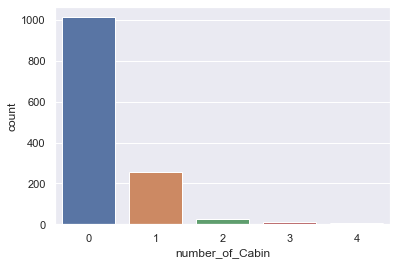

In [293]:
sns.countplot(log_bin_one_hot_df["number_of_Cabin"])

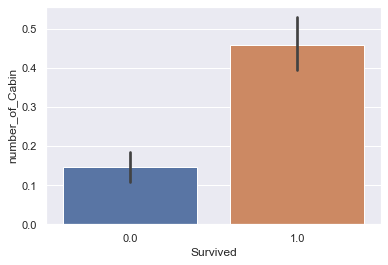

                     number_of_Cabin  log_number_of_Cabin  Survived
number_of_Cabin                 1.00                 0.92      0.28
log_number_of_Cabin             0.92                 1.00      0.31
Survived                        0.28                 0.31      1.00


In [292]:
temp_df = pd.merge(log_bin_one_hot_df[["number_of_Cabin", "log_number_of_Cabin"]], y_true, left_index=True, right_index=True)
sns.barplot(x="Survived", y="number_of_Cabin", data=temp_df)
plt.show()
print(temp_df.corr())

### Feature Elimination

In [39]:
features = log_bin_one_hot_df.columns.tolist()
features

['PassengerId',
 'Name',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'base_fare',
 'Cabin',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'parch_l1',
 'parch_l2',
 'parch_l3',
 'parch_l4',
 'SibSp_l1',
 'SibSp_l2',
 'SibSp_l3',
 'SibSp_l4',
 'log_fare',
 'is_mr',
 'is_miss',
 'is_mrs',
 'is_pc',
 'is_ca',
 'is_paris',
 'is_soton',
 'is_ston',
 'is_so',
 'is_cabin_none',
 'is_cabin_a',
 'is_cabin_b',
 'is_cabin_c',
 'is_cabin_d',
 'is_cabin_e',
 'is_cabin_f',
 'is_cabin_g']

In [40]:
all_df = log_bin_one_hot_df.copy(deep=True)

elimination_features= ['PassengerId','Name','Cabin','Ticket']
for col_name in elimination_features:
    all_df.drop(col_name , axis=1, inplace=True)

In [41]:
all_df

,Age,SibSp,Parch,base_fare,Embarked_C,Embarked_Q,Embarked_S,parch_l1,parch_l2,parch_l3,...,is_ston,is_so,is_cabin_none,is_cabin_a,is_cabin_b,is_cabin_c,is_cabin_d,is_cabin_e,is_cabin_f,is_cabin_g
0,22.00,1,0,7.25,0,0,1,1,0,0,...,False,False,True,False,False,False,False,False,False,False
1,38.00,1,0,71.28,1,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
2,26.00,0,0,7.92,0,0,1,1,0,0,...,True,True,True,False,False,False,False,False,False,False
3,35.00,1,0,53.10,0,0,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
4,35.00,0,0,8.05,0,0,1,1,0,0,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,24.82,0,0,8.05,0,0,1,1,0,0,...,False,False,True,False,False,False,False,False,False,False
1305,39.00,0,0,108.90,1,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
1306,38.50,0,0,7.25,0,0,1,1,0,0,...,False,False,True,False,False,False,False,False,False,False
1307,24.82,0,0,8.05,0,0,1,1,0,0,...,False,False,True,False,False,False,False,False,False,False


In [42]:
X_train = all_df[:number_of_train_dataset].values
X_test = all_df[number_of_train_dataset:].values
y_train = y_true.copy()

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)
clf.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [44]:
idx = (all_df[number_of_train_dataset:].index+1).tolist()
y_pre = clf.predict(X_test)  

submission_columns = ["PassengerId","Survived"]
submission_df = pd.DataFrame( [idx,y_pre]).T
submission_df.columns = submission_columns
for col_name in submission_columns:
    submission_df[col_name] = submission_df[col_name].astype(int)
submission_df.to_csv("submission.csv", index=False)